Import Libraries

In [5]:
from pyvis.network import Network
import matplotlib.pyplot as plt
import networkx as nx
import random
from helpers import createPaper, getCommNodes, splitCommunity, genGraphFeatures

Define initial parameters

In [6]:
# define time steps
timeSteps = 30

# Probabilities
# probability that you generate new author
probNewAuthor = 0.5
# probability that you stop at a given node
probStop = 0.7
# probability that a split event occurs
pd = 0.5

# define initial scholars, will be in form (id, scholarField, color)
scholarField = 0
nodeID = 0


Create Model

In [7]:
network = nx.Graph()
network.add_node(nodeID, label=scholarField, color="red")
# go through time steps, add new scholar and paper at each step
for i in range(1, timeSteps):

    # Choose first author, either new scholar or random choice
    currNodes = list(network.nodes())
    authors = [random.choice(currNodes)]

    # with probability, add new author to network set as main author with a coauthor
    if random.random() < probNewAuthor:
        # generate author and field
        nodeID += 1
        author = nodeID

        # generate random coauthor from currNodes,
        coauthorID = random.choice(currNodes)

        # add node with field being the co-author's field
        scholarField = network.nodes[coauthorID]["label"]
        network.add_node(author, label=scholarField, color="red")
        network.add_edge(author, coauthorID, weight=1, width=1)

        # update authors list
        authors = [author, coauthorID]

    # Add new paper, calling function
    createPaper(network, authors, probStop)

    # split random discipline with prob pd
    if random.random() < pd:
        commNodes = getCommNodes(network, 0)
        splitCommunity(network, commNodes)

0
1
2
3
4


Display Network

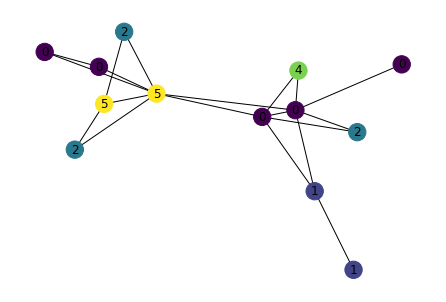

In [8]:
pos = nx.spring_layout(network, seed=3068)  # Seed layout for reproducibility
nodeLabels, nodeColors = genGraphFeatures(network)
nx.draw(network, pos=pos, with_labels=True, labels=nodeLabels, node_color=nodeColors)
plt.show()

In [9]:
nt = Network()
# populates the nodes and edges data structures
nt.from_nx(network)
print(network.nodes.data())
print(nt.get_network_data())
nt.show('docs/models/modularity.html')

[(0, {'label': 0, 'color': 'red', 'size': 10}), (1, {'label': 0, 'color': 'red', 'size': 10}), (2, {'label': 5, 'color': 'red', 'size': 10}), (3, {'label': 4, 'color': 'blue', 'size': 10}), (4, {'label': 5, 'color': 'red', 'size': 10}), (5, {'label': 1, 'color': 'orange', 'size': 10}), (6, {'label': 2, 'color': 'purple', 'size': 10}), (7, {'label': 1, 'color': 'orange', 'size': 10}), (8, {'label': 0, 'color': 'red', 'size': 10}), (9, {'label': 2, 'color': 'red', 'size': 10}), (10, {'label': 2, 'color': 'red', 'size': 10}), (11, {'label': 0, 'color': 'red', 'size': 10}), (12, {'label': 0, 'color': 'red', 'size': 10})]
([{'color': 'red', 'size': 10, 'id': 0, 'label': 0, 'shape': 'dot'}, {'color': 'red', 'size': 10, 'id': 1, 'label': 1, 'shape': 'dot'}, {'color': 'red', 'size': 10, 'id': 2, 'label': 5, 'shape': 'dot'}, {'color': 'blue', 'size': 10, 'id': 3, 'label': 4, 'shape': 'dot'}, {'color': 'orange', 'size': 10, 'id': 5, 'label': 1, 'shape': 'dot'}, {'color': 'purple', 'size': 10, 'i